In [5]:
pip install -q nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.1 MB/s eta 0:00:00


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfTransformer
import nlpaug.augmenter.word as naw
import numpy as np
from sklearn.utils import shuffle

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
data = pd.read_csv('/content/train.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [10]:
data.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
data['label'].unique()

array([0, 1])

<Axes: ylabel='label'>

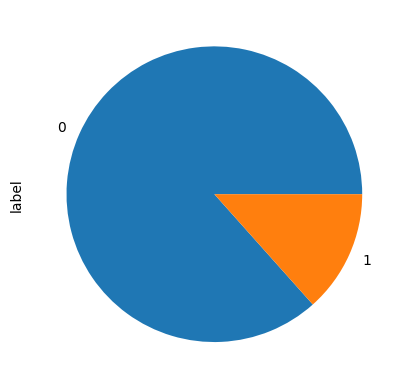

In [12]:
data['label'].value_counts().plot.pie()

In [13]:
value_count_1 = len(data[data['label'] == 1])
value_count_0 = len(data[data['label'] == 0])
print(f'Value_0 = {value_count_0}\nvalue_1 = {value_count_1}')

Value_0 = 4827
value_1 = 747


In [14]:
train,test = train_test_split(data,test_size=0.2, random_state=16, shuffle=True)

Аугментация датасета

In [15]:
train_augmented=[]
aug = naw.SynonymAug(aug_src='wordnet', model_path=None, name='Synonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng',
                     stopwords=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, force_reload=False,
                     verbose=0)
class_data = train[train['label'] == 1]
augmented_data = [aug.augment(text) for text in class_data['sms']]
train_augmented = pd.concat([train, pd.DataFrame(augmented_data, columns=['sms'])], ignore_index=True)
train_augmented['label'].fillna(1, inplace=True)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [16]:
value_count_1 = len(train_augmented[train_augmented['label'] == 1])
value_count_0 = len(train_augmented[train_augmented['label'] == 0])
print(f'Value_0 = {value_count_0}\nvalue_1 = {value_count_1}')
print(train_augmented.shape)

Value_0 = 3847
value_1 = 1224
(5071, 2)


In [17]:
value_count_1 = len(train[train['label'] == 1])
value_count_0 = len(train[train['label'] == 0])
print(f'Value_0 = {value_count_0}\nvalue_1 = {value_count_1}')
print(train.shape)

Value_0 = 3847
value_1 = 612
(4459, 2)


Предобработка текста

In [18]:
stop_words = set(stopwords.words('english'))
wordtok = nltk.tokenize.RegexpTokenizer('\w+')

def filtered_text(text):
    tokenzized_text = wordtok.tokenize(text)
    lowered_tokenized_text = [token.lower() for token in tokenzized_text]
    filtered_tokens = [word for word in lowered_tokenized_text if word not in stop_words]
    joined_string = ' '.join(filtered_tokens)
    return joined_string

In [19]:
train_augmented['clean_text']= train_augmented['sms'].apply(filtered_text)
test['clean_text']= test['sms'].apply(filtered_text)

In [20]:
test.to_csv('test.csv', sep=',', index=False)
train_augmented.to_csv('train_augmented.csv', sep=',', index=False)

In [21]:
X_train = train_augmented['clean_text']
y_train = train_augmented['label']
X_test = test['clean_text']
y_test = test['label']

In [22]:
vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

Классическая модель

В качестве модели была выбрана Logistic Regression, так как эта модель широко испольуется для задач бинарной классификации.


In [23]:
classic_model = LogisticRegression()

In [24]:
classic_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [25]:
predictions = classic_model.predict(X_test_tfidf)

In [26]:
accuracy_classic = accuracy_score(y_test, predictions)
classification_report_classic = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy_classic}')
print(f'class_rep: {classification_report_classic}')

Accuracy: 0.9748878923766816
class_rep:               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.94      0.84      0.89       135

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [27]:
input_text = 'ACTION REQUIRED. Please verify your Bank of America account information to avoid a hold on your account. Click here to confirm: [Link]'
input_text_filtered = filtered_text(input_text)
input_text_vec = vectorizer.transform([input_text_filtered])
input_text_tfidf = tfidf_transformer.transform(input_text_vec)
prediction = classic_model.predict(input_text_vec)
print(prediction[0])


1.0


Нейронная сеть

In [28]:
# конвертируем в тензоры
X_train_tensor = torch.from_numpy(X_train_tfidf.toarray()).float()
X_test_tensor = torch.from_numpy(X_test_tfidf.toarray()).float()
y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

Так как это задача бинарной классификации и в целом задача доволно простая, в качестве архитектуры модели я выбрала многослойный персептрон, который содержит входной слой, 128 скрытых слоев и выходной слой

In [29]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [30]:
input_size = X_train_tensor.shape[1]
hidden_size = 128
output_size = 1

Инициализация модели

In [42]:
nn_model = SpamClassifier(input_size, hidden_size, output_size)
loss = nn.BCEWithLogitsLoss()  # бинарная кросс энтропия (подходит для задач бинарной классификации)
optimizer = optim.Adam(nn_model.parameters())

Обучение модели

In [43]:
num_epochs = 2500
for epoch in range(num_epochs):
    # Forward propgation
    preds = nn_model(X_train_tensor)
    loss_ = loss(preds.squeeze(), y_train)  # squeeze уираетпроблему с dimention

    # Backward propogation
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_.item()}')

Epoch [100/2500], Loss: 0.06425166130065918
Epoch [200/2500], Loss: 0.013970998115837574
Epoch [300/2500], Loss: 0.006330573465675116
Epoch [400/2500], Loss: 0.003698191838338971
Epoch [500/2500], Loss: 0.0024560121819376945
Epoch [600/2500], Loss: 0.0017606141045689583
Epoch [700/2500], Loss: 0.0013274275697767735
Epoch [800/2500], Loss: 0.0010372541146352887
Epoch [900/2500], Loss: 0.0008324247319251299
Epoch [1000/2500], Loss: 0.0006821569404564798
Epoch [1100/2500], Loss: 0.0005685934447683394
Epoch [1200/2500], Loss: 0.000481051072711125
Epoch [1300/2500], Loss: 0.00041201230487786233
Epoch [1400/2500], Loss: 0.00035646557807922363
Epoch [1500/2500], Loss: 0.0003113069979008287
Epoch [1600/2500], Loss: 0.0002739756600931287
Epoch [1700/2500], Loss: 0.00024277810007333755
Epoch [1800/2500], Loss: 0.0002165203623007983
Epoch [1900/2500], Loss: 0.00019419709860812873
Epoch [2000/2500], Loss: 0.0001750892261043191
Epoch [2100/2500], Loss: 0.0001586003345437348
Epoch [2200/2500], Loss:

Тестирование модели

In [44]:
with torch.no_grad():
    outputs = nn_model(X_test_tensor)
    predictions = torch.round(torch.sigmoid(outputs)).squeeze().numpy() #используем сигмноидную функцию чтобы привести аутпуты в значеня между 0 и 1

# конвертируем predictions в бинарные значение
predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test.numpy(), predictions)
classification_rep = classification_report(y_test.numpy(), predictions)

print(f'Accuracy: {accuracy}')
print(f'Class_rep: {classification_rep}')


Accuracy: 0.9820627802690582
Class_rep:               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       0.95      0.90      0.92       135

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Тестирование на произвольном тексте

In [45]:
input_text = 'ACTION REQUIRED. Please verify your Bank of America account information to avoid a hold on your account. Click here to confirm: [Link]'
filtered_input_text = filtered_text(input_text)
text_vec = vectorizer.transform([filtered_input_text])
text_tensor = torch.tensor(text_vec.toarray()).float()

with torch.no_grad():
    text_output = nn_model(text_tensor)
    prediction = torch.round(torch.sigmoid(text_output)).squeeze().numpy() #используем сигмноидную функцию чтобы привести аутпуты в значеня между 0 и 1

# конвертируем predictions в бинарные значение
prediction = (prediction > 0.5).astype(int)
print(prediction)

1


Выводы: нейронная сеть справляется с задачей лучше, чем логичская регресссия, что видно из метрик accuracy, recall и precision
